This is just a summary of my results up until now 

In [171]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
import os 
#chnage directory C:\Users\gsent\Desktop\3rd Year Research(NOT_SURE)\Dissertation\Python Code\2nd Semester
os.chdir("C:\\Users\\gsent\\Desktop\\3rd Year Research(NOT_SURE)\\Dissertation\\Python Code\\2nd Semester")


# Load the data
data = pd.read_csv("Connectivity_Indexed.csv").dropna()
data2 = pd.read_csv('Filtered_Participant_SNP.csv')


brain_df = pd.read_csv("Connectivity_Indexed.csv")
snp_df = pd.read_csv('Filtered_Participant_SNP.csv')
snp_names = pd.read_excel('20_SNP.xlsx')

# Remove rows with NaN values
data = data.dropna()

# Ensure indices are aligned before dropping NaNs--?> 
#Combination 1.--> this was the random one selected networks + DMN 1 and 2 
#  Y = brain_df[['DMN 1 ', 'DMN 2 ','SMN 1', 'SMN 2', 'SMN 6', 'SMN 9', 'SMN 12', 'SMN 14', 'DAN 2 ', 'DAN 3', 'CN 1 ', 'CN 2 ', 'CN 4', 'CN 6', 'VN 1 ', 'VN 7', 'VN 10']]\

#combination 2 --> Elastic net regression selected network--> significant 
#Y = brain_df[['DMN 4','DMN 1','DMN 2', 'CN 4','VN 6','DAN 5','SMN 8','SN 1']]

#combination 6 --> just attempting to see if the networks 
Y = brain_df[['DMN 1', 'DMN 2', 'DMN 4', ]]
#combination 7--> Random forest to SNP selected networks
#Y = brain_df[['SMN 10', 'SMN 13', 'DAN 9', 'DAN 1', 'SN 4', 'VN 2', 'VN 6', 'VN 10', 'DAN 5', 'DAN 8', 'SN 2', 'CN 6', 'CN 3', 'VN 1', 'DAN 10', 'VN 7', 'DAN 7', 'CN 2', 'SN 5', 'DAN 11']]


#combination 3 --> ML regression selected networks  --> 
#Y = brain_df[['VN 10', 'DAN 5', 'VN 6', 'DAN 10', 'CN 6', 'DAN 7', 'DAN 11', 'CN 3', 'VN 2 ', 'DAN 8', 'SMN 4', 'VN 1 ', 'SMN 8', 'DAN 2 ', 'CN 5', 'CN 2 ', 'VN 7', 'SMN 3 ', 'VN 3', 'DMN 2 ']]

#combination 4 --> CAIDE selected networks
#Y = brain_df[['DMN 2 ', 'SMN 1', 'SMN 2', 'SMN 6', 'SMN 8', 'SMN 9', 'SMN 12', 'SMN 13', 'SMN 14', 'DAN 2 ', 'DAN 3', 'CN 1 ', 'CN 2 ', 'CN 3', 'CN 4', 'CN 6', 'VN 1 ', 'VN 7', 'VN 9', 'VN 10']]

#combination --> XG boosted trees selected networks
#Y = brain_df[['CN 2 ', 'CN 5', 'DAN 7', 'VN 2 ', 'DAN 3', 'DAN 2 ', 'VN 10', 'DAN 10', 'CN 6', 'VN 9', 'SMN 3 ', 'CN 3', 'VN 4', 'VN 6', 'CN 4', 'VN 7', 'DAN 5', 'SMN 6', 'CN 1 ', 'DAN 6']]

#combination 5 --> ALL selected networks

X = snp_df[['rs28394864_A', 'rs602602_A', 'rs12151021_A', 'rs429358_C', 'rs1354106_G', 'rs4663105_C', 
            'rs6069737_T', 'rs679515_T', 'rs1582763_A', 'rs1532278_A', 'rs561655_G', 'rs11218343_G', 
            'rs7146179_A', 'rs12590654_A', 'rs1846190_A', 'rs187370608_A', 'rs9369716_T', 'rs7912495_G', 
            'rs7384878_C', 'rs3935067_C']]

data3 = pd.read_excel('20_SNP.xlsx')
      
# Rename SNPs in X based on data3
for i, col in enumerate(X.columns):
    match = data3[data3['Lead Variant'].str[:6] == col[:6]]
    if not match.empty:
        X.columns.values[i] = match['Gene'].values[0]



In [172]:
# Drop NaN rows to align the datasets
Y = Y.dropna()
print(f"Shape of data after filtering: {data.shape}")
print(f"Shape of data2 after filtering: {data2.shape}")

# Save original labels for plotting
snp_labels = X.columns.tolist()
network_labels = Y.columns.tolist()

# Scale the data--> it's actually centered. 
X_centered = X - X.mean()
X_scaled = X_centered / X.std()
Y_centered = Y - Y.mean()
Y_scaled = Y_centered / Y.std()

# Perform Canonical Correlation Analysis (CCA)
cca = CCA(n_components=min(X.shape[1], Y.shape[1]))
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

# Compute canonical correlations
correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
r_squared = [corr ** 2 for corr in correlations]

print("Canonical Correlations:", correlations)
print("R-squared values:", r_squared)

Shape of data after filtering: (482, 53)
Shape of data2 after filtering: (482, 26)
Canonical Correlations: [0.32814953287085813, 0.2144989442430624, 0.1447815182460288]
R-squared values: [0.1076821159233624, 0.046009797081388394, 0.02096168802562517]


In [173]:
# Wilk’s Lambda test
def canonical_correlation_test(canonical_corrs, N, px, py):
    m = min(px, py)
    lambdas = [(1 / (1 - gamma**2)) - 1 for gamma in canonical_corrs]

    wilks = np.zeros(m)
    wilks[-1] = 1 / (1 + lambdas[-1])
    for j in range(m-2, -1, -1):
        wilks[j] = (1 / (1 + lambdas[j])) * wilks[j + 1]

    results = []
    for j in range(m):
        df_j = (px - j) * (py - j)
        chi_sq_j = -np.log(wilks[j]) * (N - (px + py + 3) / 2)
        p_value = 1 - chi2.cdf(chi_sq_j, df_j)

        results.append((wilks[j], chi_sq_j, df_j, p_value))
        print(f"Canonical Correlation {j+1}: Wilk's Lambda={wilks[j]:.4f}, "
              f"Chi-Square={chi_sq_j:.4f}, df={df_j}, p-value={p_value:.4f}")
    return results

N = X.shape[0]
px, py = X.shape[1], Y.shape[1]
results = canonical_correlation_test(correlations, N, px, py)



Canonical Correlation 1: Wilk's Lambda=0.8334, Chi-Square=85.4608, df=60, p-value=0.0171
Canonical Correlation 2: Wilk's Lambda=0.9340, Chi-Square=32.0263, df=38, p-value=0.7413
Canonical Correlation 3: Wilk's Lambda=0.9790, Chi-Square=9.9355, df=18, p-value=0.9340


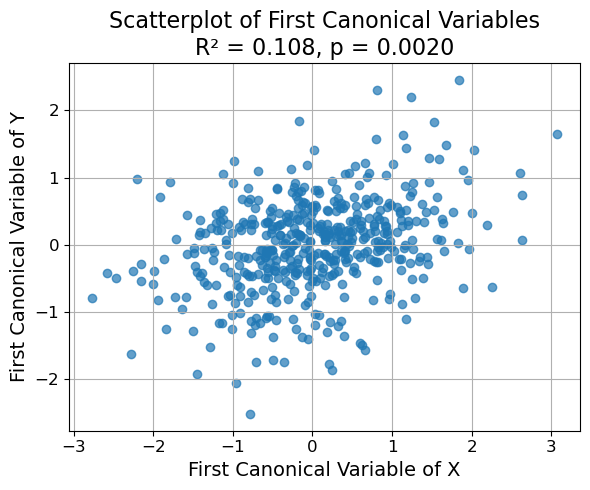

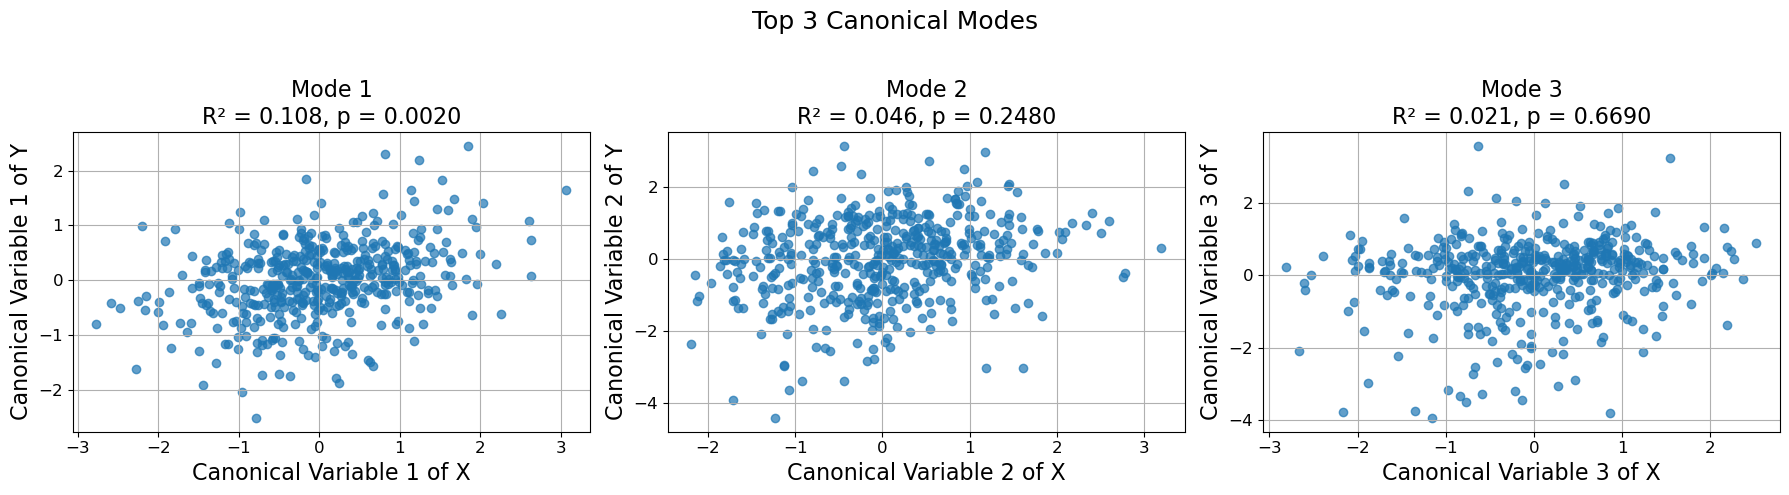

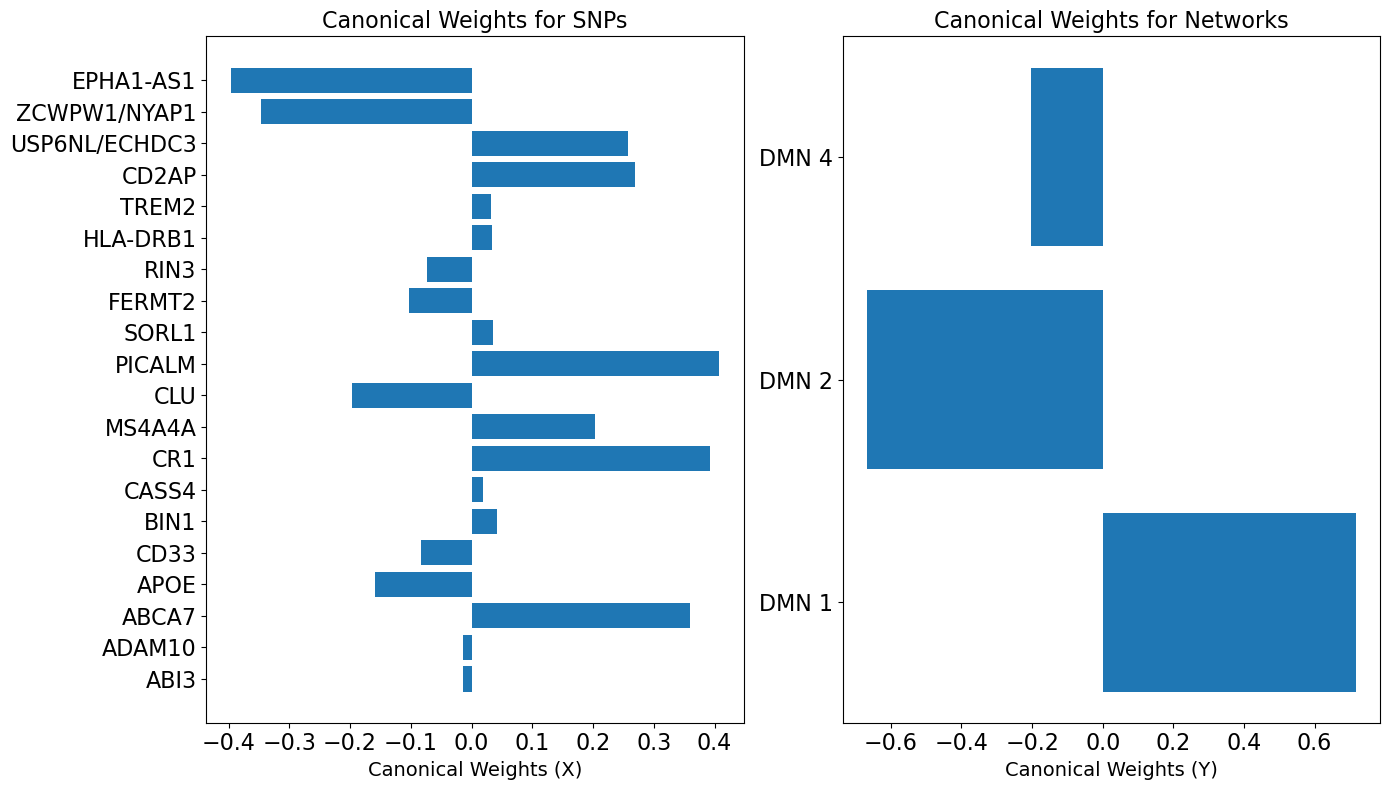

In [174]:
import matplotlib.pyplot as plt

# === Scatterplot of First Canonical Pair ===
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0], alpha=0.7)
plt.xlabel('First Canonical Variable of X', fontsize=14)
plt.ylabel('First Canonical Variable of Y', fontsize=14)
plt.title(f'Scatterplot of First Canonical Variables\nR² = {r_squared[0]:.3f}, p = {empirical_pvals[0]:.4f}', fontsize=16)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# === Scatterplots for Top 3 Canonical Modes ===
n_modes = min(3, cca.n_components)
fig, axes = plt.subplots(1, n_modes, figsize=(6 * n_modes, 5))

for i in range(n_modes):
    ax = axes[i] if n_modes > 1 else axes
    ax.scatter(X_c[:, i], Y_c[:, i], alpha=0.7)
    ax.set_xlabel(f'Canonical Variable {i+1} of X', fontsize=16)
    ax.set_ylabel(f'Canonical Variable {i+1} of Y', fontsize=16)
    ax.set_title(f'Mode {i+1}\nR² = {r_squared[i]:.3f}, p = {empirical_pvals[i]:.4f}', fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=12)

fig.suptitle("Top 3 Canonical Modes", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Canonical Weights ===
plt.figure(figsize=(14, 8))

# SNP weights
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(snp_labels)), cca.x_weights_[:, 0], align='center')
plt.yticks(np.arange(len(snp_labels)), snp_labels, fontsize=16)
plt.xlabel('Canonical Weights (X)', fontsize=14)
plt.title('Canonical Weights for SNPs', fontsize=16)
plt.xticks(fontsize=16)

# Network weights
plt.subplot(1, 2, 2)
plt.barh(np.arange(len(network_labels)), cca.y_weights_[:, 0], align='center')
plt.yticks(np.arange(len(network_labels)), network_labels, fontsize=16)
plt.xlabel('Canonical Weights (Y)', fontsize=14)
plt.title('Canonical Weights for Networks', fontsize=16)
plt.xticks(fontsize=16)

plt.tight_layout()
plt.show()


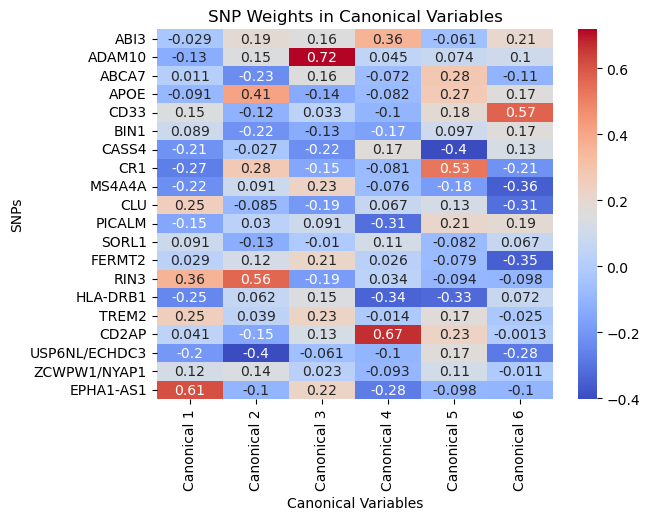

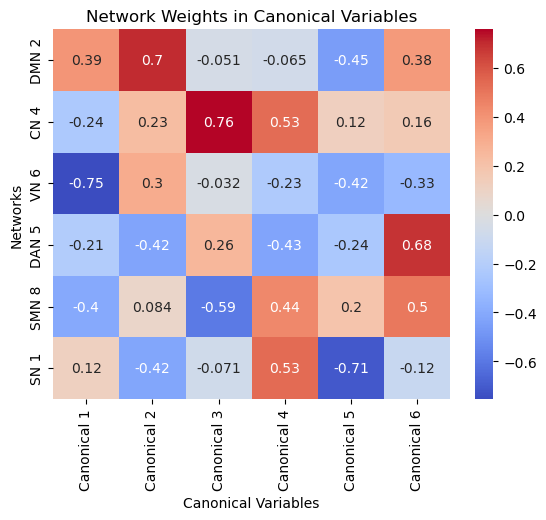

In [20]:
sns.heatmap(cca.x_weights_, annot=True, cmap='coolwarm', 
            xticklabels=[f'Canonical {i+1}' for i in range(cca.n_components)], 
            yticklabels=snp_labels)
plt.title('SNP Weights in Canonical Variables')
plt.xlabel('Canonical Variables')
plt.ylabel('SNPs')
plt.show()

sns.heatmap(cca.y_weights_, annot=True, cmap='coolwarm', 
            xticklabels=[f'Canonical {i+1}' for i in range(cca.n_components)], 
            yticklabels=network_labels)
plt.title('Network Weights in Canonical Variables')
plt.xlabel('Canonical Variables')
plt.ylabel('Networks')
plt.show()

Heatmap of correlations of the vairbales to the canonical variables 

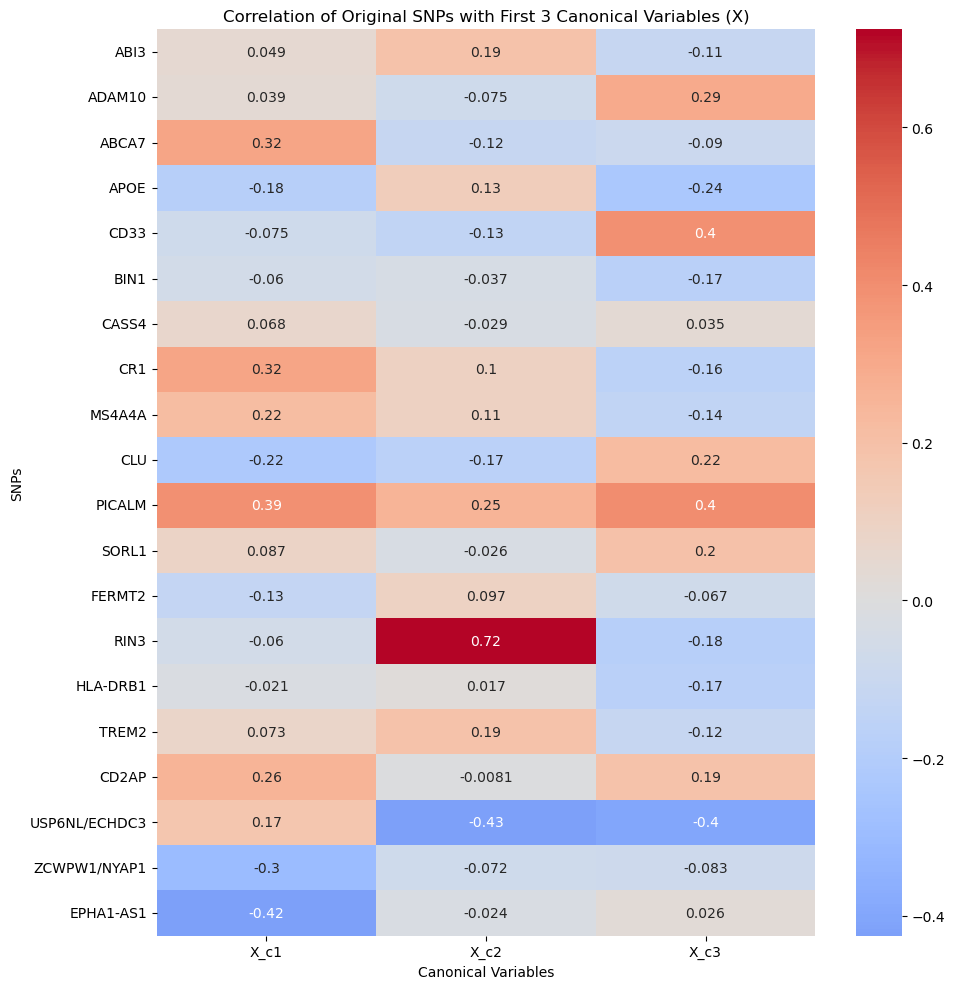

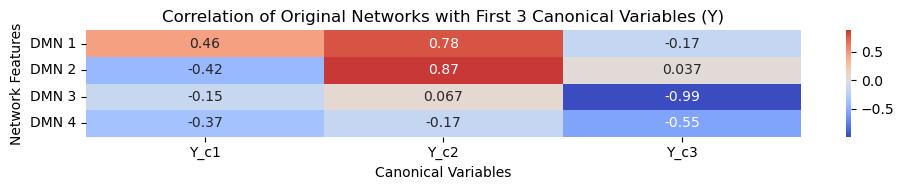

In [139]:
# Compute correlation of original variables with canonical variables (first 3 components only)
X_corrs = pd.DataFrame(np.corrcoef(X_scaled.T, X_c.T)[:X_scaled.shape[1], X_scaled.shape[1]:],
                       index=snp_labels, columns=[f'X_c{i+1}' for i in range(X_c.shape[1])])
X_corrs = X_corrs.iloc[:, :3]  # Select only first 3 canonical variables

Y_corrs = pd.DataFrame(np.corrcoef(Y_scaled.T, Y_c.T)[:Y_scaled.shape[1], Y_scaled.shape[1]:],
                       index=network_labels, columns=[f'Y_c{i+1}' for i in range(Y_c.shape[1])])
Y_corrs = Y_corrs.iloc[:, :3]  # Select only first 3 canonical variables

# Plot heatmap for SNPs (first 3 components)
plt.figure(figsize=(10, len(snp_labels) * 0.5))
sns.heatmap(X_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Original SNPs with First 3 Canonical Variables (X)')
plt.xlabel('Canonical Variables')
plt.ylabel('SNPs')
plt.tight_layout()
plt.show()

# Plot heatmap for Networks (first 3 components)
plt.figure(figsize=(10, len(network_labels) * 0.5))
sns.heatmap(Y_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Original Networks with First 3 Canonical Variables (Y)')
plt.xlabel('Canonical Variables')
plt.ylabel('Network Features')
plt.tight_layout()
plt.show()



# Why are the weights the same as the loadings? 
🔁 2. High Multicollinearity Within Sets
If variables within X or Y are highly correlated, the canonical variates (i.e., linear combinations) end up distributing similar weights across those variables — and those same variables will have similar correlations with the canonical variate.

So:

Canonical weights reflect how much a variable contributes to the variate.

Correlations reflect how strongly a variable follows the variate.

When groups of variables move together, these two measures line up more closely.

Permutation Testing --> shuffles data and runs it 450 time shows us where the distribution of our previous R^2 lies --> P value diffeent wilk's lamda does not take into account the parametyers

Running permutation test...

Permutation Test Results:
Canonical correlation 1: R² = 0.1077, p-value = 0.0030
Canonical correlation 2: R² = 0.0460, p-value = 0.2260
Canonical correlation 3: R² = 0.0210, p-value = 0.6490


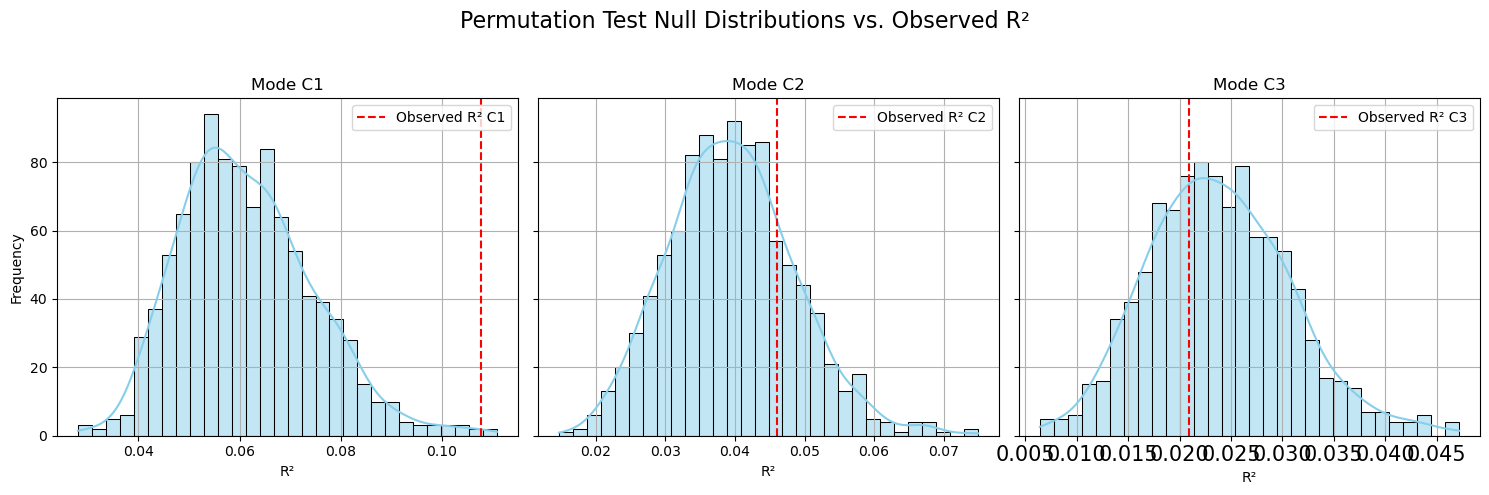

In [175]:

np.random.seed(42)  # Optional for reproducibility
n_permutations = 1000
perm_r2 = np.zeros((n_permutations, cca.n_components))

print("Running permutation test...")

for i in range(n_permutations):
    perm_indices = np.random.permutation(Y_scaled.shape[0])

    X_perm = X_scaled.iloc[perm_indices, :]  # Permute the rows of Y
    cca_perm = CCA(n_components=min(X.shape[1], Y.shape[1]))
    X_c_perm, Y_c_perm = cca_perm.fit_transform(X_perm, Y_scaled)
    for j in range(cca_perm.n_components):
        corr = np.corrcoef(X_c_perm[:, j], Y_c_perm[:, j])[0, 1]
        perm_r2[i, j] = corr ** 2

# Compute empirical p-values
empirical_pvals = np.mean(perm_r2 >= r_squared, axis=0)

print("\nPermutation Test Results:")
for i, p in enumerate(empirical_pvals):
    print(f"Canonical correlation {i+1}: R² = {r_squared[i]:.4f}, p-value = {p:.4f}")

# Plot null distribution and observed R²# Plot each canonical mode in a separate subplot
n_modes = min(3, cca.n_components)  # The 2 here limits the number of modes to at most 2 for visualization purposes.
fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 5), sharey=True)

for i in range(n_modes):
    ax = axes[i]
    sns.histplot(perm_r2[:, i], bins=30, kde=True, color="skyblue", ax=ax)
    ax.axvline(r_squared[i], color='red', linestyle='--', label=f"Observed R² C{i+1}")
    ax.set_title(f"Mode C{i+1}")
    ax.set_xlabel("R²")
    if i == 0:
        ax.set_ylabel("Frequency")
    
    ax.legend()
    ax.grid(True)

fig.suptitle("Permutation Test Null Distributions vs. Observed R²", fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Explanation of the above p value calculation 
For Component 1:
Observed R² = 0.25
Permutation R²s = [0.20, 0.26, 0.30, 0.22, 0.27]
Values ≥ 0.25: [0.26, 0.30, 0.27] → 3 out of 5
So: p1 = 3 / 5 = 0.6

For Component 2:
Observed R² = 0.10
Permutation R²s = [0.05, 0.08, 0.11, 0.10, 0.15]
Values ≥ 0.10: [0.11, 0.10, 0.15] → 3 out of 5
So: p2 = 3 / 5 = 0.6

Suggestions for improvement:
You might want to shuffle both X and Y for some tests

Consider using np.random.permutation for clearer row-wise shuffling

For very small p-values, you might want more permutations (1000+)

You could add confidence intervals to your null distribution plots

Observed Wilks' Lambda: 0.8334
Permutation p-value: 0.0170


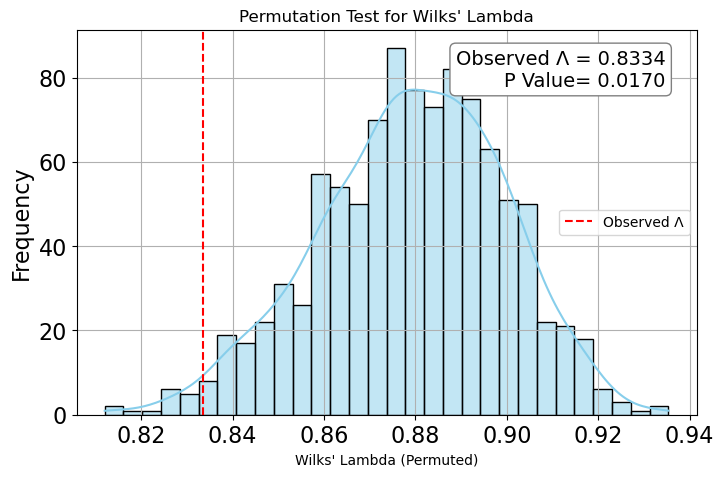

In [176]:
from sklearn.cross_decomposition import CCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fit original CCA
k = min(X.shape[1], Y.shape[1])
cca = CCA(n_components=k)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

# Compute canonical correlations
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(k)]
r_squared = np.array(canonical_corrs) ** 2
wilks_lambda_observed = np.prod(1 - r_squared)

# Run permutation test
np.random.seed(42)  # For reproducibility
n_permutations = 1000
perm_wilks = np.zeros(n_permutations)
perm_r2 = np.zeros((n_permutations, k))

for i in range(n_permutations):
    # Permute Y (preserving structure of X)
    Y_perm = Y_scaled.iloc[np.random.permutation(Y_scaled.shape[0]), :]
    
    cca_perm = CCA(n_components=k)
    X_c_perm, Y_c_perm = cca_perm.fit_transform(X_scaled, Y_perm)
    
    # Canonical correlations for permuted data
    perm_corrs = [np.corrcoef(X_c_perm[:, j], Y_c_perm[:, j])[0, 1] for j in range(k)]
    perm_r2[i, :] = np.array(perm_corrs) ** 2
    perm_wilks[i] = np.prod(1 - perm_r2[i, :])

# Compute global Wilks' p-value
p_value = np.mean(perm_wilks <= wilks_lambda_observed)

# Compute per-mode p-values
empirical_pvals = np.mean(perm_r2 >= r_squared, axis=0)

print(f"Observed Wilks' Lambda: {wilks_lambda_observed:.4f}")
print(f"Permutation p-value: {p_value:.4f}")

# Plot Wilks' Lambda distribution
plt.figure(figsize=(8, 5))
sns.histplot(perm_wilks, bins=30, kde=True, color="skyblue")
plt.axvline(wilks_lambda_observed, color='red', linestyle='--', label="Observed Λ")
plt.xlabel("Wilks' Lambda (Permuted)")
plt.ylabel("Frequency", fontsize=16)
plt.title("Permutation Test for Wilks' Lambda")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.grid(True)

# Add annotation with R² and p-value
plt.text(0.95, 0.95, f"Observed Λ = {wilks_lambda_observed:.4f}\nP Value= {p_value:.4f}",fontsize= 14,
             transform=plt.gca().transAxes, va='top', ha='right',
             bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))
plt.show()





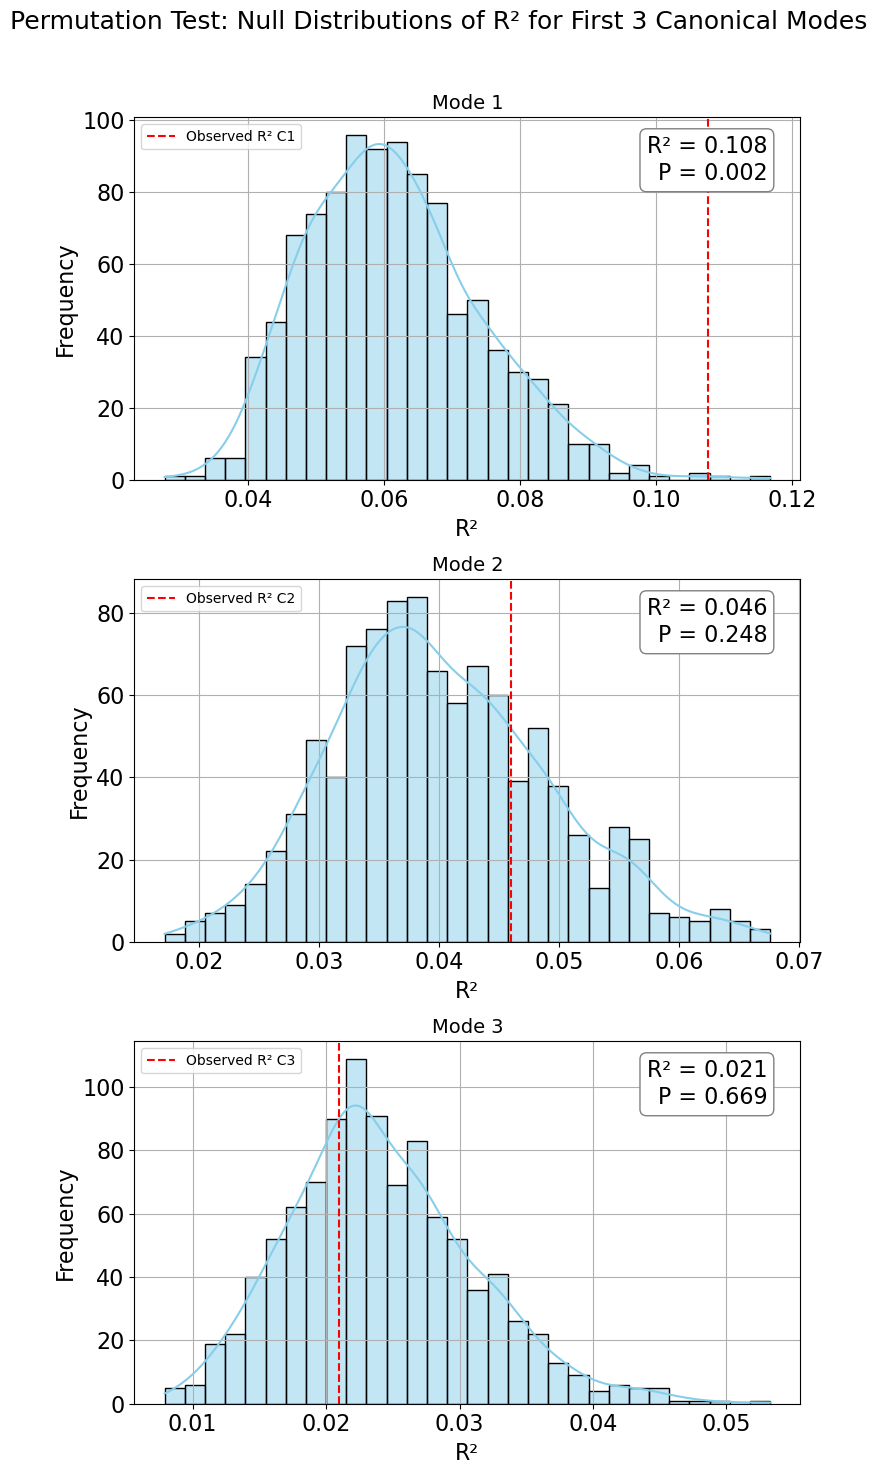

In [152]:
# Plot R² null distributions for first 3 modes (vertically stacked)
n_modes = min(3, k)
fig, axes = plt.subplots(nrows=n_modes, ncols=1, figsize=(8, 5 * n_modes), sharex=False)

for i in range(n_modes):
    ax = axes[i] if n_modes > 1 else axes
    sns.histplot(perm_r2[:, i], bins=30, kde=True, color="skyblue", ax=ax)
    ax.axvline(r_squared[i], color='red', linestyle='--', label=f"Observed R² C{i+1}")
    ax.set_title(f"Mode {i+1}", fontsize=14)
    ax.set_xlabel("R²", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
    ax.legend()
    ax.tick_params(axis='both', labelsize=16)


    # Add annotation with R² and p-value
    ax.text(0.95, 0.95, f"R² = {r_squared[i]:.3f}\nP = {empirical_pvals[i]:.3f}", fontsize=16,
            transform=ax.transAxes, va='top', ha='right',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

    ax.grid(True)
    

fig.suptitle("Permutation Test: Null Distributions of R² for First 3 Canonical Modes", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


What does this show? This means that the observed lamda from earlier --> my observed result from earlier falls within the null hypothesis. --> mean of the proportion of permuted wilk's lmada that are samller than my wilk's lamda 

1. Wilks’ Lambda Interpretation

Smaller Λ = Stronger association (Λ → 0 means strong correlation).

Larger Λ = Weaker/no association (Λ → 1 means no correlation).

2. Null Distribution vs. Observed Λ

If your observed Λ is smaller than most permuted Λ values, it means:

Your CCA result is stronger than random chance (significant, small p-value).

If your observed Λ is larger than most permuted Λ values (like your case, p=0.68), it means:

Your CCA result is consistent with noise (not significant).

3. Why <= and not >=?

Because Λ measures lack of association (unlike R², where larger = stronger).

You want to know if your observed Λ is unusually small (i.e., association is unusually strong).

In [177]:
from sklearn.model_selection import KFold

# Set up KFold
k = 4  # or 10, depending on your dataset size
kf = KFold(n_splits=k, shuffle=True, random_state=42)

r2_scores = []

print(f"\nRunning {k}-Fold Cross-Validation...\n")
fold = 4

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    Y_train, Y_test = Y_scaled.iloc[train_idx], Y_scaled.iloc[test_idx]
    
    cca_cv = CCA(n_components=min(X.shape[1], Y.shape[1]))
    X_c_train, Y_c_train = cca_cv.fit_transform(X_train, Y_train)
    X_c_test, Y_c_test = cca_cv.transform(X_test, Y_test)

    # Compute canonical correlations on test set
    test_corrs = [np.corrcoef(X_c_test[:, i], Y_c_test[:, i])[0, 1] for i in range(cca_cv.n_components)]
    test_r2 = [corr ** 2 for corr in test_corrs]
    r2_scores.append(test_r2)

    print(f"Fold {fold} - R² values: {test_r2}")
    fold += -1

# Average R² across folds
r2_scores = np.array(r2_scores)
mean_r2 = r2_scores.mean(axis=0)
std_r2 = r2_scores.std(axis=0)

print("\nAverage R² across folds:")
for i, (mean, std) in enumerate(zip(mean_r2, std_r2)):
    print(f"Canonical Correlation {i+1}: Mean R² = {mean:.4f} ± {std:.4f}")





Running 4-Fold Cross-Validation...

Fold 4 - R² values: [0.039421967907927125, 0.0018391041771638843, 0.009978056947287248]
Fold 3 - R² values: [0.04027265801043787, 0.0020100013076794396, 0.018555475565207893]
Fold 2 - R² values: [0.008350847156506244, 0.0024245981218657202, 0.003235409431485287]
Fold 1 - R² values: [0.06938261084368397, 0.00610939128762612, 0.0002771012744280803]

Average R² across folds:
Canonical Correlation 1: Mean R² = 0.0394 ± 0.0216
Canonical Correlation 2: Mean R² = 0.0031 ± 0.0018
Canonical Correlation 3: Mean R² = 0.0080 ± 0.0070


Issues with the above 
--> 

-Monitor standard deviation of performance across folds — high variance = be cautious in conclusions.

-High Variance or Small Data?	Can be problematic if not handled carefully	Use repeated K-Fold or fewer splits

In [178]:
# Calculate Redundancy Indices
# Step 1: Compute structure coefficients (correlation of original variables with canonical variates)
X_struct_corrs = np.corrcoef(X_scaled.T, X_c.T)[:X.shape[1], X.shape[1]:]
Y_struct_corrs = np.corrcoef(Y_scaled.T, Y_c.T)[:Y.shape[1], Y.shape[1]:]

# Step 2: Calculate proportion of variance explained by canonical variates for each set
# For set X (how much of X is explained by its canonical variates)
var_explained_X = np.mean(X_struct_corrs**2, axis=0)
# For set Y (how much of Y is explained by its canonical variates)
var_explained_Y = np.mean(Y_struct_corrs**2, axis=0)

# Step 3: Multiply by squared canonical correlations to get redundancy
redundancy_X = var_explained_X * r_squared
redundancy_Y = var_explained_Y * r_squared

# Display results
redundancy_df = pd.DataFrame({
    "Canonical Correlation": correlations,
    "Squared R": r_squared,
    "Variance Explained in X": var_explained_X,
    "Redundancy of X by Y": redundancy_X,
    "Variance Explained in Y": var_explained_Y,
    "Redundancy of Y by X": redundancy_Y
})

print("\nRedundancy Index Table:")
print(redundancy_df.round(4))




Redundancy Index Table:
   Canonical Correlation  Squared R  Variance Explained in X  \
0                 0.3281     0.1077                   0.0449   
1                 0.2145     0.0460                   0.0472   
2                 0.1448     0.0210                   0.0492   

   Redundancy of X by Y  Variance Explained in Y  Redundancy of Y by X  
0                0.0048                   0.1742                0.0188  
1                0.0022                   0.4721                0.0217  
2                0.0010                   0.3537                0.0074  
